In [1]:
import torch
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader, RandomSampler
from tqdm.notebook import tqdm

from models.energy_models import EnergyAttentionRNN, EnergyAttentionRNN2D
from data_utils.pytorch_datasets import EnergyDataset, EnergyDataset2D
from plotting_utils.attention import attention_2D_viz

In [2]:
checkpoint_path_2D = './model_weights/energy/rnn_attn/2D_GRU_1L_1H/model.ckpt'

model_2D = EnergyAttentionRNN2D.load_from_checkpoint(checkpoint_path_2D)
model_2D.eval()

EnergyAttentionRNN2D(
  (rnn): GRU(1, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=1, bias=True)
  (attention_rows): MultiheadAttention(
    (out_proj): Linear(in_features=512, out_features=512, bias=True)
  )
  (attention_cols): MultiheadAttention(
    (out_proj): Linear(in_features=512, out_features=512, bias=True)
  )
)

In [3]:
train_data_path = './data/train_data.hdf5'
batch_size = 128
n_random_samples = 3200

ising_dataset = EnergyDataset2D(filepath=train_data_path)
random_sampler = RandomSampler(ising_dataset, num_samples=n_random_samples, replacement=True)
train_dataloader = DataLoader(
    ising_dataset,
    batch_size=batch_size,
    sampler=random_sampler,
    num_workers=0)

In [4]:
attn_weights_rows = torch.zeros((batch_size, 63, 63))
attn_weights_cols = torch.zeros((batch_size, 63, 63))
y_preds = []
y_true = []
with torch.no_grad():
    for x_row, x_col, y in tqdm(train_dataloader):
        y_pred, attn_weights = model_2D(x_row, x_col)
        if y_pred.shape[0] == batch_size:
            attn_weights_rows += attn_weights[0]
            attn_weights_cols += attn_weights[1]
        y_preds.append(y_pred)
        y_true.append(y)

energies_pred = torch.cat(y_preds, axis=0)
energies_pred_centered = energies_pred - torch.mean(energies_pred)

energies_true = torch.cat(y_true, axis=0)
energies_true_centered = energies_true- torch.mean(energies_true)
attn_weights_sum = (attn_weights_rows, attn_weights_cols)

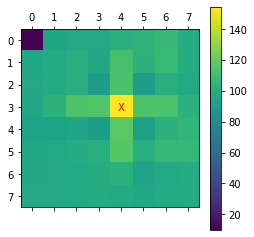

In [5]:
row, col = 3, 4
attn_viz = attention_2D_viz(attn_weights_sum, row, col)
plt.matshow(attn_viz)
plt.text(col, row, "X",ha="center", va="center", color="r")
plt.colorbar()